In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [53]:
all_out = glob("out/**/*.pkl")

In [54]:
all_out = [load_pickle(p) for p in all_out]

In [55]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "target": out["target"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["xgb_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["xgb_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["xgb_metrics"]["f1_micro"],
        "kappa": out["baseline"]["xgb_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["tabpfn_metrics"]["f1_micro"],
        "kappa": out["baseline"]["tabpfn_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [56]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [57]:
res

,train_size,frac_valid,accuracy,f1_macro,f1_micro,kappa,num_classes,target
0,10,1.000,0.228000,0.155294,0.228000,0.03500,5,"(logKH_CH4, CH4 Henry coefficient)"
1,10,1.000,0.556000,0.514614,0.556000,0.11200,2,"(logKH_CO2, CO2 Henry coefficient)"
2,20,1.000,0.524000,0.520617,0.524000,0.04800,2,"(logKH_CH4, CH4 Henry coefficient)"
3,20,1.000,0.176000,0.160479,0.176000,-0.03000,5,"(logKH_CH4, CH4 Henry coefficient)"
4,10,0.996,0.180723,0.153787,0.180723,-0.02267,5,"(logKH_CO2, CO2 Henry coefficient)"
5,10,1.000,0.492000,0.485071,0.492000,-0.01600,2,"(logKH_CO2, CO2 Henry coefficient)"
6,10,1.000,0.600000,0.563822,0.600000,0.20000,2,"(logKH_CH4, CH4 Henry coefficient)"
7,10,1.000,0.536000,0.516667,0.536000,0.07200,2,"(logKH_CH4, CH4 Henry coefficient)"
8,10,1.000,0.528000,0.514291,0.528000,0.05600,2,"(logKH_CO2, CO2 Henry coefficient)"
9,10,1.000,0.524000,0.506560,0.524000,0.04800,2,"(logKH_CH4, CH4 Henry coefficient)"


In [58]:
grouped_res = res.groupby(["num_classes", "target", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [59]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [60]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [61]:
grouped_res.loc[2, :]

frac_valid           accuracy  \
                                                    mean  std  sem     mean   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10                1.0  0.0  0.0    0.533   
                                   20                1.0  NaN  NaN    0.524   
(logKH_CO2, CO2 Henry coefficient) 10                1.0  0.0  0.0    0.508   

                                                                   f1_macro  \
                                                    std       sem      mean   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.052599  0.026300  0.513732   
                                   20               NaN       NaN  0.520617   
(logKH_CO2, CO2 Henry coefficient) 10          0.043451  0.021726  0.492485   

                                                                  f1_micro  \
                                                    std       sem     mean   
target                             train_size                                
(logKH_CH4, CH4 Henry coefficient) 10          0.039461  0.019730    0.533   
                                   20               NaN       NaN    0.524   
(logKH_CO2, CO2 Henry coefficient) 10          0.028011  0.014006    0.508   

                                                                   kappa  \
                                                    std       sem   mean   
target                             train_size                              
(logKH_CH4, CH4 Henry coefficient) 10          0.052599  0.026300  0.066   
                                   20               NaN       NaN  0.048   
(logKH_CO2, CO2 Henry coefficient) 10          0.043451  0.021726  0.016   

                                                                   
                                                    std       sem  
target                             train_size                      
(logKH_CH4, CH4 Henry coefficient) 10          0.105198  0.052599  
                                   20               NaN       NaN  
(logKH_CO2, CO2 Henry coefficient) 10          0.086902  0.043451

In [62]:
grouped_xgboost_res

accuracy            \
                                                              mean  std  sem   
num_classes target                             train_size                      
2           (logKH_CH4, CH4 Henry coefficient) 10            0.500  0.0  0.0   
                                               20            0.436  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10            0.500  0.0  0.0   
5           (logKH_CH4, CH4 Henry coefficient) 10            0.200  NaN  NaN   
                                               20            0.208  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10            0.200  NaN  NaN   
                                               20            0.200  NaN  NaN   

                                                           f1_macro            \
                                                               mean  std  sem   
num_classes target                             train_size                       
2           (logKH_CH4, CH4 Henry coefficient) 10          0.333333  0.0  0.0   
                                               20          0.431186  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.333333  0.0  0.0   
5           (logKH_CH4, CH4 Henry coefficient) 10          0.066667  NaN  NaN   
                                               20          0.206504  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.066667  NaN  NaN   
                                               20          0.191643  NaN  NaN   

                                                          f1_micro            \
                                                              mean  std  sem   
num_classes target                             train_size                      
2           (logKH_CH4, CH4 Henry coefficient) 10            0.500  0.0  0.0   
                                               20            0.436  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10            0.500  0.0  0.0   
5           (logKH_CH4, CH4 Henry coefficient) 10            0.200  NaN  NaN   
                                               20            0.208  NaN  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10            0.200  NaN  NaN   
                                               20            0.200  NaN  NaN   

                                                           kappa            
                                                            mean  std  sem  
num_classes target                             train_size                   
2           (logKH_CH4, CH4 Henry coefficient) 10          0.000  0.0  0.0  
                                               20         -0.128  NaN  NaN  
            (logKH_CO2, CO2 Henry coefficient) 10          0.000  0.0  0.0  
5           (logKH_CH4, CH4 Henry coefficient) 10          0.000  NaN  NaN  
                                               20          0.010  NaN  NaN  
            (logKH_CO2, CO2 Henry coefficient) 10          0.000  NaN  NaN  
                                               20          0.000  NaN  NaN

In [63]:
grouped_res.loc[2, :].index[0][0]

('logKH_CH4', 'CH4 Henry coefficient')

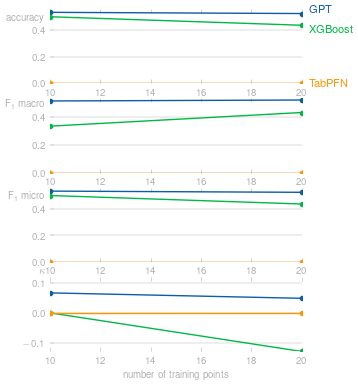

In [64]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("logKHCH4-classification_results_binary.pdf", bbox_inches="tight")

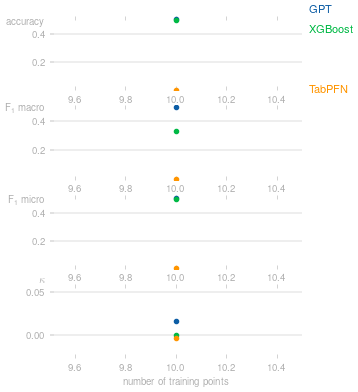

In [65]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            - grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            + grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            - grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            + grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("logKHCO2-classification_results_binary.pdf", bbox_inches="tight")

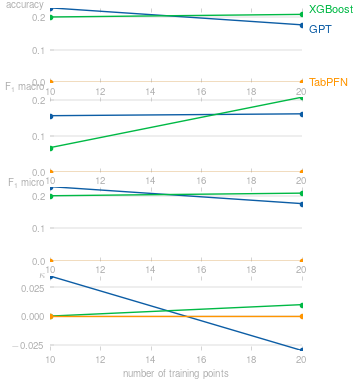

In [66]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
            alpha=0.5,
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("logKHCH4-classification_results_5.pdf", bbox_inches="tight")